In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import h5py
import numpy as np
np.set_printoptions(suppress=True)
import math
import matplotlib.pyplot as plt
import MEArec as mr
from collections import defaultdict
from decay_model.utility_functions import clustering_plotting_functions
import spikeextractors as se
import spiketoolkit as st
#import spikecomparison as sc
import spikeinterface.comparison as sc
from tqdm.notebook import tqdm
from sklearn.cluster import MeanShift
import wandb

# sklearn import errors
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture

from collections import namedtuple

TrainSpike = namedtuple('DataPoint', ['amps', 'waveforms', 'ch_locs', 'center_loc', 'spike_id', 'exp_id',\
                                      'min_waveform', 'min_amp'])
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

import matplotlib as mpl
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 
mpl.rcParams.update({'font.size': 12})

In [100]:
recording_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/'
augmented_data_path = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/save files 3/'
recording_name = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
width = 40
amp_jitter = 0

recgen = mr.load_recordings(recording_directory + recording_name)
channel_positions = recgen.channel_positions
soma_positions = np.asarray([st.annotations['soma_position'] for st in recgen.spiketrains])
SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)

hf_AO = h5py.File(str(augmented_data_path) + 'model_data_gt_'+ str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
amp_array = np.asarray(hf_AO['amplitude'])
channel_loc_array = np.asarray(hf_AO['channel_locations'])
waveforms_array = np.asarray(hf_AO['waveforms'])
center_loc_array = np.asarray(hf_AO['center_locations'])
spike_time_list = np.asarray(hf_AO['spike_times'])
spike_id_list = np.asarray(hf_AO['spike_ids'])
hf_AO.close()

hf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_gt_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
neuron_loc_array = np.asarray(hf_label_AO['neuron_locations'])
neuron_array = np.asarray(hf_label_AO['neurons'])
hf_label_AO.close()

'''
hf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')
neuron_loc_array = np.asarray(hf_label_AO['neuron_loc_list'])
neuron_array = np.asarray(hf_label_AO['neuron_list'])
overlap_array = np.asarray(hf_label_AO['overlap_list'])
hf_label_AO.close()

'''

"\nhf_label_AO = h5py.File(str(augmented_data_path) + 'label_data_' + str(width) + 'um_VAE_'+str(amp_jitter)+'_amp_jitter_' + str(recording_name), 'r')\nneuron_loc_array = np.asarray(hf_label_AO['neuron_loc_list'])\nneuron_array = np.asarray(hf_label_AO['neuron_list'])\noverlap_array = np.asarray(hf_label_AO['overlap_list'])\nhf_label_AO.close()\n\n"

In [101]:
waveform_len = 60
results_path = "save files 3/" + "loc_predictions_"+str(width) + "_" + str(amp_jitter) + "_amp_jit_wave_"+str(waveform_len)+".txt"
all_vae_errors = defaultdict(list)
vae_locs_2D = defaultdict(list)
vae_locs_3D = defaultdict(list)
all_neuron_waveforms = defaultdict(list)
all_spike_times = defaultdict(list)
index = 0
with open(results_path,"r") as f:
    for result_string in f:
        result_tokens = [float(i) for i in result_string.split(',')]
        est_loc = [float(token) for token in result_tokens[0:3]]
        max_waveform = [float(token) for token in result_tokens[3:3+waveform_len]]
        spike_time = int(result_tokens[3+waveform_len])
        neuron_id = int(result_tokens[3+waveform_len+1])
        neuron_loc = soma_positions[neuron_id]
        vae_locs_2D[neuron_id].append([est_loc[1], est_loc[2]])
        vae_locs_3D[neuron_id].append([est_loc[0], est_loc[1], est_loc[2]])
        
        error_dist = np.linalg.norm(est_loc[1:3] - neuron_loc[1:3])
        all_neuron_waveforms[neuron_id].append(max_waveform)
        all_spike_times[neuron_id].append(spike_time)
        index += 1
        all_vae_errors[neuron_id].append(error_dist)
print(results_path)

save files 3/loc_predictions_40_0_amp_jit_wave_60.txt


In [102]:
spike_number = 0
neuron_error = 0
neuron_std = 0 
neuron_errors_all = []
neuron_stds_all = []
spike_errors_all = []


for neuron in range(50):#good_indices:#range(50):
    if(len(all_vae_errors[neuron]) != 0):
        neuron_error = np.mean(all_vae_errors[neuron])
        neuron_std = np.std(all_vae_errors[neuron])
        spike_number += len(all_vae_errors[neuron])
        spike_errors_all = spike_errors_all + all_vae_errors[neuron]
        neuron_errors_all.append(neuron_error)
        neuron_stds_all.append(neuron_std)
print("Total Spike 2D Error: " + str(np.mean(spike_errors_all)) + " +- " + str(np.std(spike_errors_all)))
print("Total Neuron 2D Error: " + str(np.mean(neuron_errors_all)) + " +- " + str(np.mean(neuron_stds_all)))


# wandb.init(project="dissertation_new", entity="zelihasag", config = {
#     "Total Spike 2D Error_VAE": str(np.mean(spike_errors_all)) + " +- " + str(np.std(spike_errors_all)),
#     "Total Neuron 2D Error_VAE": str(np.mean(neuron_errors_all)) + " +- " + str(np.mean(neuron_stds_all))
# })


Total Spike 2D Error: 9.8781940706246 +- 11.535070158085956
Total Neuron 2D Error: 10.851315021192889 +- 8.624780209331004


In [10]:
neu_errors_old = defaultdict(list)
for i in range(50):
    unit_error = np.mean(all_vae_errors[i])
    neu_errors_old[i].append(unit_error)

In [13]:
neu_errors_old

defaultdict(list,
            {0: [35.95770700240283],
             1: [7.279884638644076],
             2: [13.947830457603635],
             3: [10.489611187036386],
             4: [6.266642650642405],
             5: [10.876400376573683],
             6: [5.566694489925015],
             7: [14.14175411307027],
             8: [9.569217105468152],
             9: [22.416219972919333],
             10: [12.67527228114321],
             11: [21.605331774122334],
             12: [15.728168631491286],
             13: [2.2564555737889935],
             14: [10.032618507462567],
             15: [17.99123008029339],
             16: [20.845739077630547],
             17: [40.41258896143156],
             18: [13.895519240871542],
             19: [15.48897188825314],
             20: [13.087971629803665],
             21: [22.93448464337089],
             22: [18.936344337025538],
             23: [15.276980614235262],
             24: [4.9576214161531],
             25: [36.7982879936

In [84]:
neu_errors_new = defaultdict(list)
for i in range(50):
    unit_error = np.mean(all_vae_errors[i])
    neu_errors_new[i].append(unit_error)

In [85]:
neu_errors_new

defaultdict(list,
            {0: [22.684026909139206],
             1: [5.580610073943032],
             2: [5.0817104658792],
             3: [4.074716581279914],
             4: [6.547238671269062],
             5: [4.640337835155674],
             6: [4.0983352376568725],
             7: [8.351050450317755],
             8: [4.729433260524375],
             9: [6.8739488187930355],
             10: [9.103657019704139],
             11: [13.650086455950156],
             12: [11.236679981801664],
             13: [2.221953003596431],
             14: [5.810949787734439],
             15: [8.045111401382407],
             16: [12.683597862128574],
             17: [25.913390401415388],
             18: [13.277789251112228],
             19: [12.803382622516121],
             20: [5.480328895180771],
             21: [14.898114865204354],
             22: [12.269047437925034],
             23: [7.1863986828137465],
             24: [3.284991623368249],
             25: [27.26481292458

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

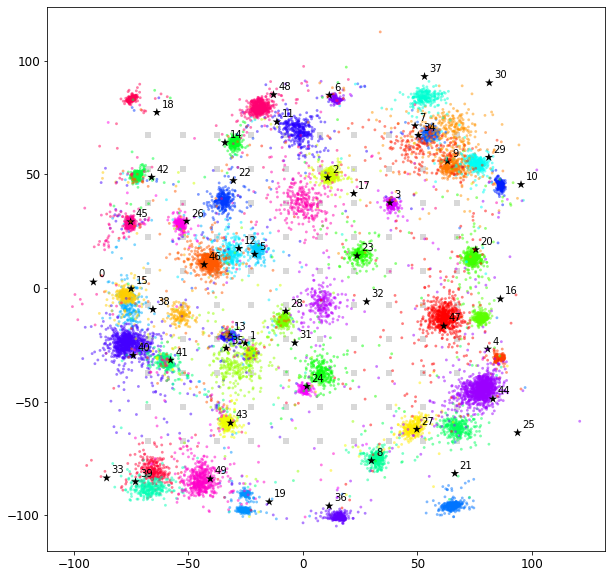

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
clustering_plotting_functions.plot2DLocations(channel_positions, range(50), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax, annotate=True);

wandb.log({
    "Estimated locations VAE colorful": wandb.Image(plt)
})


In [58]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
alpha = 16
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(all_neuron_waveforms[0][0])//2

waveforms_list = []
for neuron in range(num_neurons):
    for waveform in all_neuron_waveforms[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)

if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(num_neurons):
        for i, _ in enumerate(all_neuron_waveforms[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(all_neuron_waveforms[neuron])

cluster_data = []
labels = []
if(pc_components !=0):
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(vae_locs_3D[neuron]):
            cluster_data.append(np.concatenate((vae_loc[1:3], alpha*all_neuron_pcs[neuron][i])))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)
else:
    for neuron in range(num_neurons):
        for i, vae_loc in enumerate(vae_locs_3D[neuron]):
            cluster_data.append((vae_loc[1:3]))
            labels.append(neuron)
    cluster_data = np.asarray(cluster_data)

clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
labels =  clustering.predict(cluster_data)

#Make numpy extractor for method

SX=se.NumpySortingExtractor()
SX.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in all_spike_times[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels):
    times_k=times[np.where(labels==k)[0]]
    times_k.sort()
    SX.add_unit(unit_id=k,times=times_k)

cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
performance_measures = cmp.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures)

Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.821202
recall                  0.840283
precision               0.954640
false_discovery_rate    0.045360
miss_rate               0.159717
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

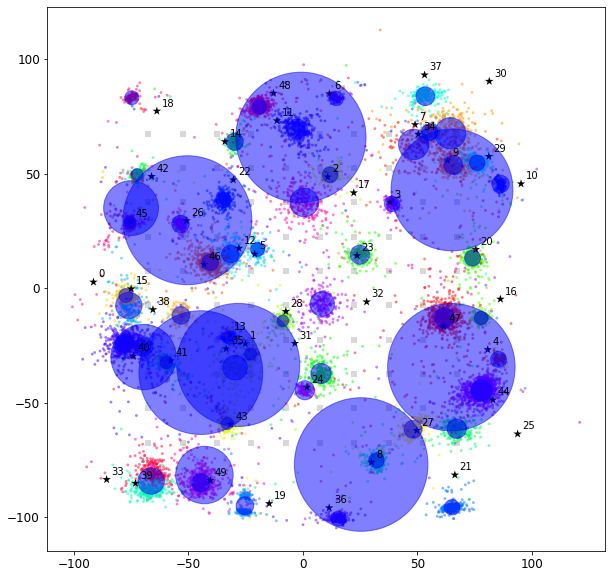

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
for i, covar in enumerate(clustering.covariances_):
    mean = clustering.means_[i]
    if covariance_type == 'full':
        covariances = covar[:2, :2]
    elif covariance_type == 'diag':
        covariances = np.diag(covar[:2])
    elif covariance_type == 'spherical':
        covariances =  np.eye(mean.shape[0]) * covar
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1],
                              180 + angle, color='blue')
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect('equal', 'datalim')
clustering_plotting_functions.plot2DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

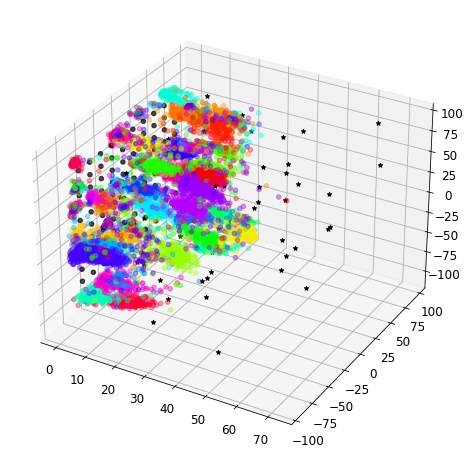

In [9]:
ax = clustering_plotting_functions.plot3DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, loc_color='blue', alpha=.4);

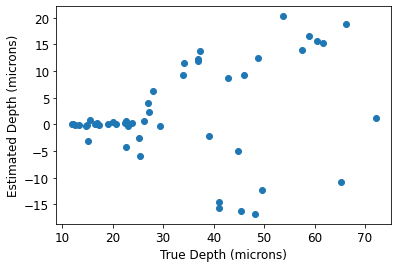

In [10]:
est_depths = []
real_depths = []
for neuron in range(50):
    real_depths.append(soma_positions[neuron][0])
    est_depths.append(np.mean(np.asarray(vae_locs_3D[neuron])[:,0]))
plt.scatter(real_depths, est_depths)
plt.ylabel("Estimated Depth (microns)")
plt.xlabel("True Depth (microns)");

## Mean Shift Clustering

In [60]:
from sklearn.cluster import MeanShift

clustering_vae= MeanShift(bandwidth=11).fit(cluster_data)
labels_vae =  clustering_vae.predict(cluster_data)

In [61]:
SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
SX_vae_ms=se.NumpySortingExtractor()
SX_vae_ms.set_sampling_frequency(32000)
times = []
for neuron in range(num_neurons):
    for time in all_spike_times[neuron]:
        times.append(time)
times = np.asarray(times)
for k in np.unique(labels_vae):
    times_k=times[np.where(labels_vae==k)[0]]
    times_k.sort()
    SX_vae_ms.add_unit(unit_id=k,times=times_k)

cmp_vae_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_vae_ms, n_jobs=1, match_score=0);
performance_measures_vae_ms = cmp_vae_ms.get_performance(method='pooled_with_average')

print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
print(performance_measures_vae_ms)

Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.832379
recall                  0.863547
precision               0.951591
false_discovery_rate    0.048409
miss_rate               0.136453
dtype: float64


# Checking the clustering parameters

  0%|          | 0/21 [00:00<?, ?it/s]

Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.758381
recall                  0.815240
precision               0.894048
false_discovery_rate    0.105952
miss_rate               0.184760
dtype: float64


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.275456
recall                  0.276940
precision               0.969688
false_discovery_rate    0.030312
miss_rate               0.723060
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.549313
recall                  0.561598
precision               0.956447
false_discovery_rate    0.043553
miss_rate               0.438402
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.685440
recall                  0.709653
precision               0.954094
false_discovery_rate    0.045906
miss_rate               0.290347
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.726219
recall                  0.774361
precision               0.920787
false_discovery_rate    0.079213
miss_rate               0.225639
dtype: float64
Alpha: 0, PCs: 2, Num Clusters: 60
accuracy                0.741013
recall                  0.804834
precision               0.893085
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.263956
recall                  0.264109
precision               0.988370
false_discovery_rate    0.011630
miss_rate               0.735891
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.536578
recall                  0.542155
precision               0.976696
false_discovery_rate    0.023304
miss_rate               0.457845
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.696516
recall                  0.714471
precision               0.960926
false_discovery_rate    0.039074
miss_rate               0.285529
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.745785
recall                  0.780729
precision               0.936323
false_discovery_rate    0.063677
miss_rate               0.219271
dtype: float64
Alpha: 1, PCs: 2, Num Clusters: 60
accuracy                0.743594
recall                  0.803575
precision               0.915090
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.238649
recall                  0.238731
precision               0.992842
false_discovery_rate    0.007158
miss_rate               0.761269
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.528608
recall                  0.529947
precision               0.988662
false_discovery_rate    0.011338
miss_rate               0.470053
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.697102
recall                  0.705707
precision               0.976911
false_discovery_rate    0.023089
miss_rate               0.294293
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.757627
recall                  0.782075
precision               0.949789
false_discovery_rate    0.050211
miss_rate               0.217925
dtype: float64
Alpha: 2, PCs: 2, Num Clusters: 60
accuracy                0.756286
recall                  0.796825
precision               0.936674
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.201884
recall                  0.201888
precision               0.998333
false_discovery_rate    0.001667
miss_rate               0.798112
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.521600
recall                  0.522792
precision               0.990608
false_discovery_rate    0.009392
miss_rate               0.477208
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.691759
recall                  0.697753
precision               0.981385
false_discovery_rate    0.018615
miss_rate               0.302247
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.748654
recall                  0.762712
precision               0.966902
false_discovery_rate    0.033098
miss_rate               0.237288
dtype: float64
Alpha: 3, PCs: 2, Num Clusters: 60
accuracy                0.769980
recall                  0.800993
precision               0.941013
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.174433
recall                  0.174433
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.825567
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.507894
recall                  0.508664
precision               0.991875
false_discovery_rate    0.008125
miss_rate               0.491336
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.682232
recall                  0.686759
precision               0.982558
false_discovery_rate    0.017442
miss_rate               0.313241
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.752668
recall                  0.766392
precision               0.965504
false_discovery_rate    0.034496
miss_rate               0.233608
dtype: float64
Alpha: 4, PCs: 2, Num Clusters: 60
accuracy                0.767988
recall                  0.791258
precision               0.956594
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.148045
recall                  0.148045
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.851955
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.474655
recall                  0.475180
precision               0.994220
false_discovery_rate    0.005780
miss_rate               0.524820
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.674162
recall                  0.677594
precision               0.987206
false_discovery_rate    0.012794
miss_rate               0.322406
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.747919
recall                  0.757239
precision               0.979544
false_discovery_rate    0.020456
miss_rate               0.242761
dtype: float64
Alpha: 5, PCs: 2, Num Clusters: 60
accuracy                0.768581
recall                  0.789670
precision               0.960181
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.118035
recall                  0.118035
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.881965
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.427867
recall                  0.428146
precision               0.993098
false_discovery_rate    0.006902
miss_rate               0.571854
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.659234
recall                  0.661406
precision               0.991216
false_discovery_rate    0.008784
miss_rate               0.338594
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.747771
recall                  0.755847
precision               0.977373
false_discovery_rate    0.022627
miss_rate               0.244153
dtype: float64
Alpha: 6, PCs: 2, Num Clusters: 60
accuracy                0.767621
recall                  0.786470
precision               0.964654
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.091954
recall                  0.091954
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.908046
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.395515
recall                  0.395741
precision               0.994348
false_discovery_rate    0.005652
miss_rate               0.604259
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.637253
recall                  0.638856
precision               0.991596
false_discovery_rate    0.008404
miss_rate               0.361144
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.745659
recall                  0.750987
precision               0.984760
false_discovery_rate    0.015240
miss_rate               0.249013
dtype: float64
Alpha: 7, PCs: 2, Num Clusters: 60
accuracy                0.768119
recall                  0.784307
precision               0.970361
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.072089
recall                  0.072089
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.927911
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.362965
recall                  0.363091
precision               0.994985
false_discovery_rate    0.005015
miss_rate               0.636909
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.622721
recall                  0.624204
precision               0.992284
false_discovery_rate    0.007716
miss_rate               0.375796
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.735278
recall                  0.739569
precision               0.987005
false_discovery_rate    0.012995
miss_rate               0.260431
dtype: float64
Alpha: 8, PCs: 2, Num Clusters: 60
accuracy                0.766413
recall                  0.780310
precision               0.974172
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.059386
recall                  0.059386
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.940614
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.332911
recall                  0.332989
precision               0.996232
false_discovery_rate    0.003768
miss_rate               0.667011
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.584355
recall                  0.585370
precision               0.993327
false_discovery_rate    0.006673
miss_rate               0.414630
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.724898
recall                  0.728347
precision               0.987552
false_discovery_rate    0.012448
miss_rate               0.271653
dtype: float64
Alpha: 9, PCs: 2, Num Clusters: 60
accuracy                0.776365
recall                  0.784802
precision               0.979951
false_

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.045792
recall                  0.045792
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.954208
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.303186
recall                  0.303236
precision               0.996304
false_discovery_rate    0.003696
miss_rate               0.696764
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.566171
recall                  0.567320
precision               0.992249
false_discovery_rate    0.007751
miss_rate               0.432680
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.710033
recall                  0.712802
precision               0.990462
false_discovery_rate    0.009538
miss_rate               0.287198
dtype: float64
Alpha: 10, PCs: 2, Num Clusters: 60
accuracy                0.769052
recall                  0.776398
precision               0.984823
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.038511
recall                  0.038511
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.961489
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.275535
recall                  0.275578
precision               0.997298
false_discovery_rate    0.002702
miss_rate               0.724422
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.539822
recall                  0.540284
precision               0.997801
false_discovery_rate    0.002199
miss_rate               0.459716
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.690574
recall                  0.693118
precision               0.993443
false_discovery_rate    0.006557
miss_rate               0.306882
dtype: float64
Alpha: 11, PCs: 2, Num Clusters: 60
accuracy                0.770660
recall                  0.775089
precision               0.988609
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.033996
recall                  0.033996
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.966004
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.256629
recall                  0.256661
precision               0.999940
false_discovery_rate    0.000060
miss_rate               0.743339
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.513749
recall                  0.514136
precision               0.994476
false_discovery_rate    0.005524
miss_rate               0.485864
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.666714
recall                  0.668819
precision               0.990441
false_discovery_rate    0.009559
miss_rate               0.331181
dtype: float64
Alpha: 12, PCs: 2, Num Clusters: 60
accuracy                0.765901
recall                  0.769804
precision               0.989596
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.031379
recall                  0.031379
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.968621
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.240541
recall                  0.240579
precision               0.995621
false_discovery_rate    0.004379
miss_rate               0.759421
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.478903
recall                  0.479136
precision               0.996386
false_discovery_rate    0.003614
miss_rate               0.520864
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.653871
recall                  0.655281
precision               0.991233
false_discovery_rate    0.008767
miss_rate               0.344719
dtype: float64
Alpha: 13, PCs: 2, Num Clusters: 60
accuracy                0.752032
recall                  0.755412
precision               0.990406
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.028527
recall                  0.028527
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.971473
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.219775
recall                  0.219804
precision               0.999932
false_discovery_rate    0.000068
miss_rate               0.780196
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.449013
recall                  0.449188
precision               0.997112
false_discovery_rate    0.002888
miss_rate               0.550812
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.624518
recall                  0.625863
precision               0.991454
false_discovery_rate    0.008546
miss_rate               0.374137
dtype: float64
Alpha: 14, PCs: 2, Num Clusters: 60
accuracy                0.737077
recall                  0.740013
precision               0.991148
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.026421
recall                  0.026421
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.973579
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.194681
recall                  0.194710
precision               0.998815
false_discovery_rate    0.001185
miss_rate               0.805290
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.428046
recall                  0.428119
precision               0.997261
false_discovery_rate    0.002739
miss_rate               0.571881
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.607449
recall                  0.608501
precision               0.993421
false_discovery_rate    0.006579
miss_rate               0.391499
dtype: float64
Alpha: 15, PCs: 2, Num Clusters: 60
accuracy                0.720945
recall                  0.723330
precision               0.991888
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.024571
recall                  0.024571
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.975429
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.172518
recall                  0.172544
precision               0.999926
false_discovery_rate    0.000074
miss_rate               0.827456
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.408539
recall                  0.408612
precision               0.995241
false_discovery_rate    0.004759
miss_rate               0.591388
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.588097
recall                  0.588969
precision               0.994312
false_discovery_rate    0.005688
miss_rate               0.411031
dtype: float64
Alpha: 16, PCs: 2, Num Clusters: 60
accuracy                0.697164
recall                  0.699589
precision               0.989998
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.022804
recall                  0.022804
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.977196
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.148557
recall                  0.148557
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.851443
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.392943
recall                  0.393007
precision               0.996895
false_discovery_rate    0.003105
miss_rate               0.606993
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.572159
recall                  0.572895
precision               0.994551
false_discovery_rate    0.005449
miss_rate               0.427105
dtype: float64
Alpha: 17, PCs: 2, Num Clusters: 60
accuracy                0.671263
recall                  0.673357
precision               0.992562
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.020272
recall                  0.020272
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.979728
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.135571
recall                  0.135574
precision               0.998824
false_discovery_rate    0.001176
miss_rate               0.864426
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.370997
recall                  0.371059
precision               0.996797
false_discovery_rate    0.003203
miss_rate               0.628941
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.554780
recall                  0.555317
precision               0.995646
false_discovery_rate    0.004354
miss_rate               0.444683
dtype: float64
Alpha: 18, PCs: 2, Num Clusters: 60
accuracy                0.671773
recall                  0.673943
precision               0.992724
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.019509
recall                  0.019509
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.980491
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.124738
recall                  0.124738
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.875262
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.346978
recall                  0.347015
precision               0.997442
false_discovery_rate    0.002558
miss_rate               0.652985
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.533284
recall                  0.533660
precision               0.997199
false_discovery_rate    0.002801
miss_rate               0.466340
dtype: float64
Alpha: 19, PCs: 2, Num Clusters: 60
accuracy                0.657357
recall                  0.659411
precision               0.992910
f

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.018724
recall                  0.018724
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.981276
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.115496
recall                  0.115496
precision               1.000000
false_discovery_rate    0.000000
miss_rate               0.884504
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.327920
recall                  0.327970
precision               0.998571
false_discovery_rate    0.001429
miss_rate               0.672030
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.515898
recall                  0.516257
precision               0.995385
false_discovery_rate    0.004615
miss_rate               0.483743
dtype: float64
Alpha: 20, PCs: 2, Num Clusters: 60
accuracy                0.639694
recall                  0.641350
precision               0.990553
f

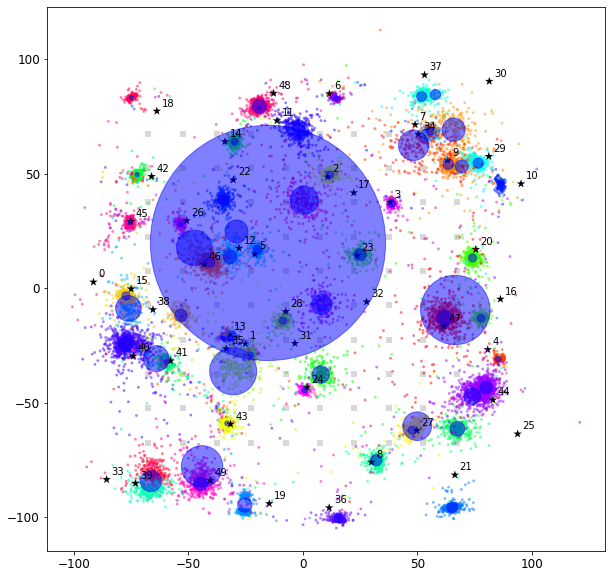

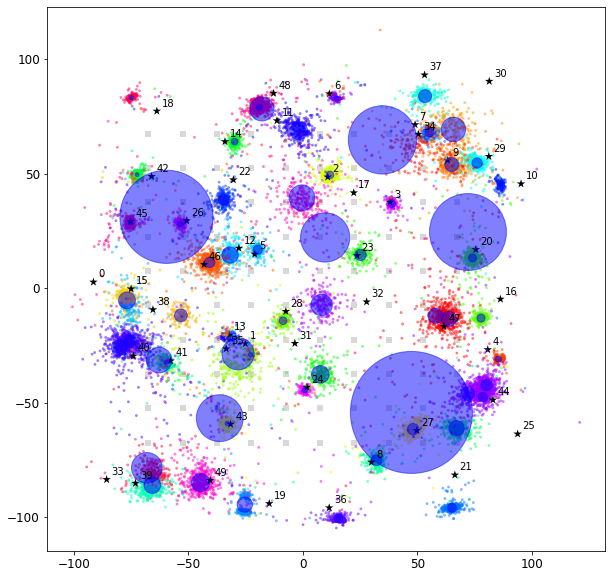

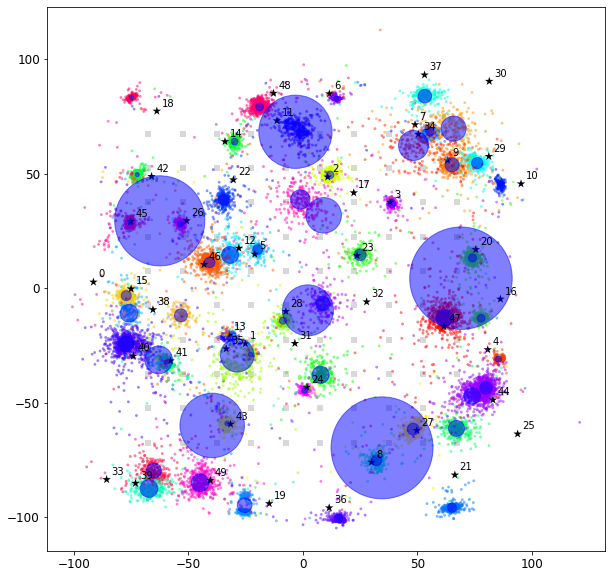

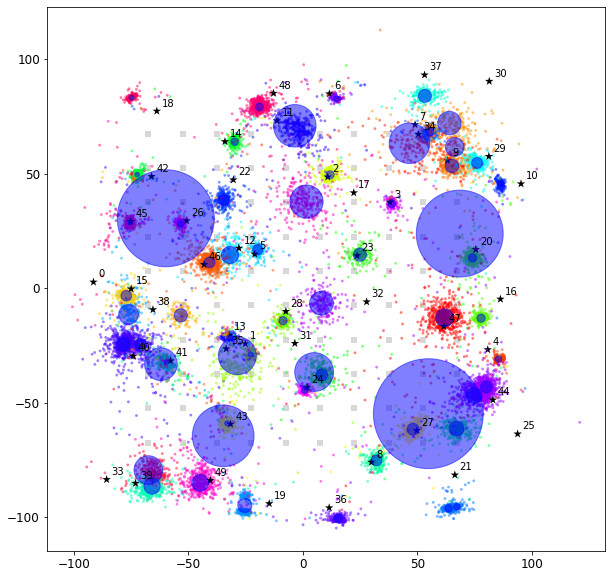

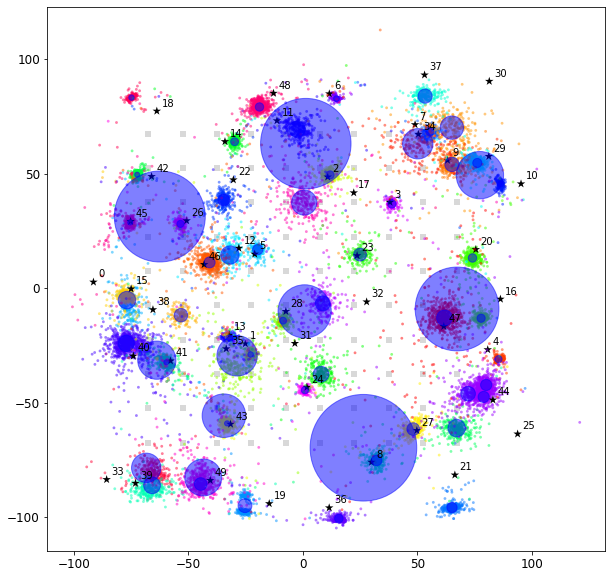

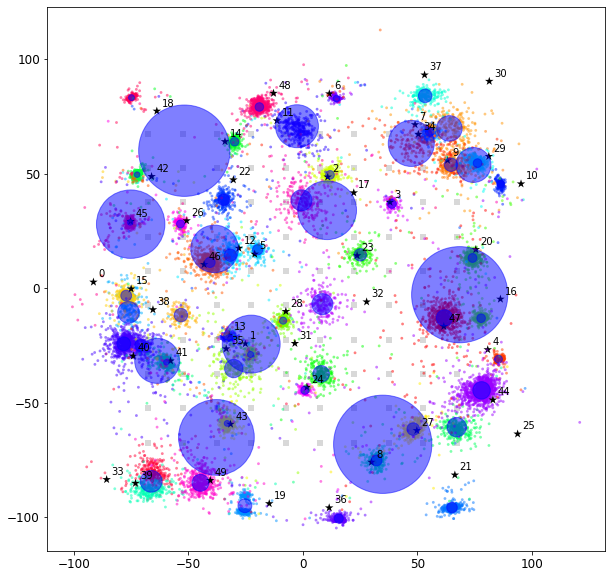

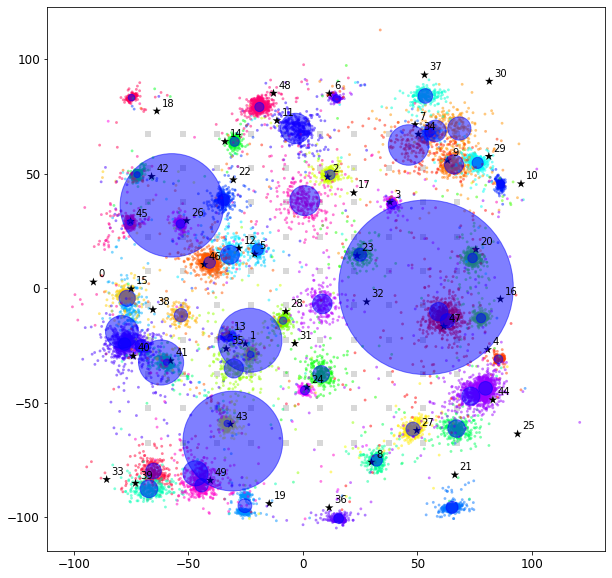

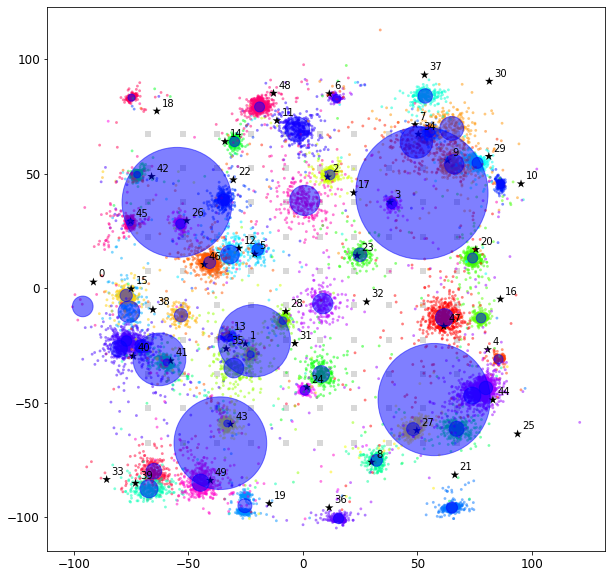

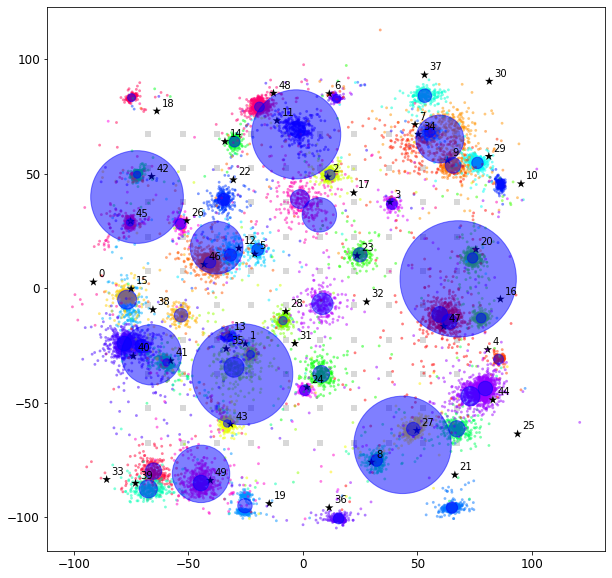

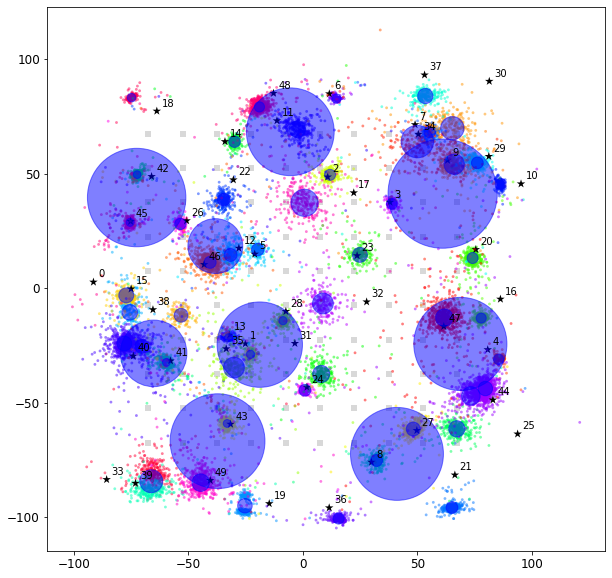

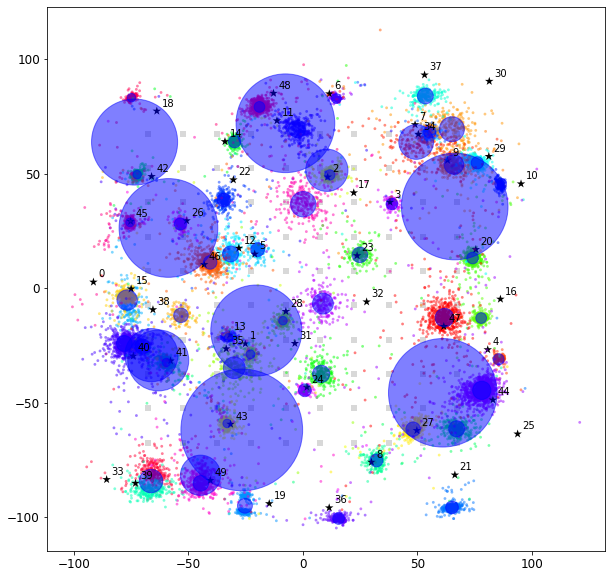

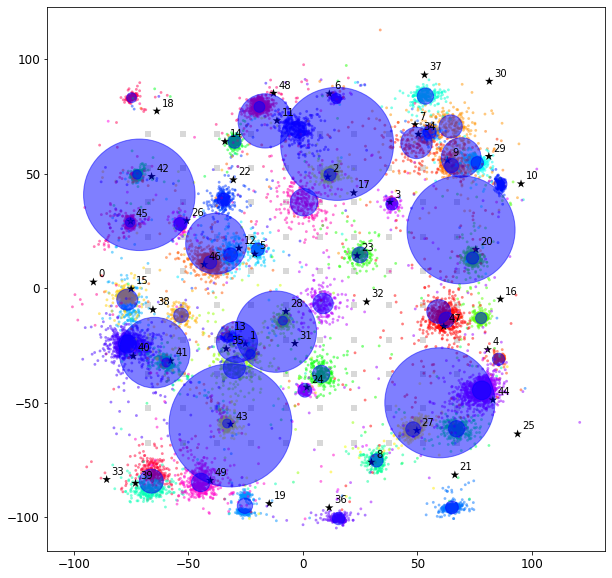

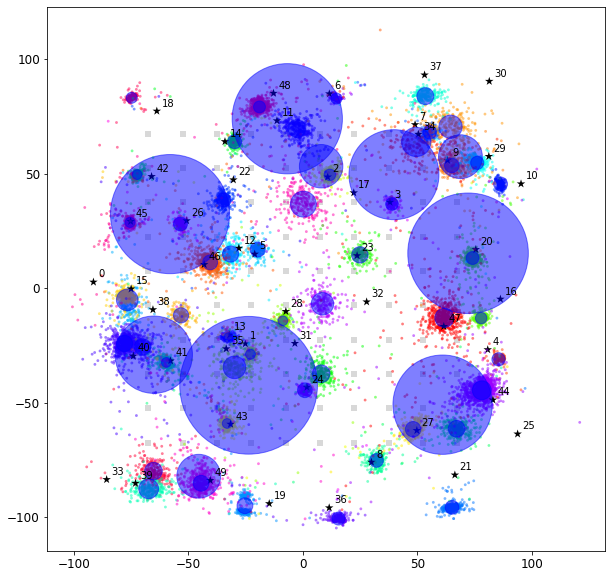

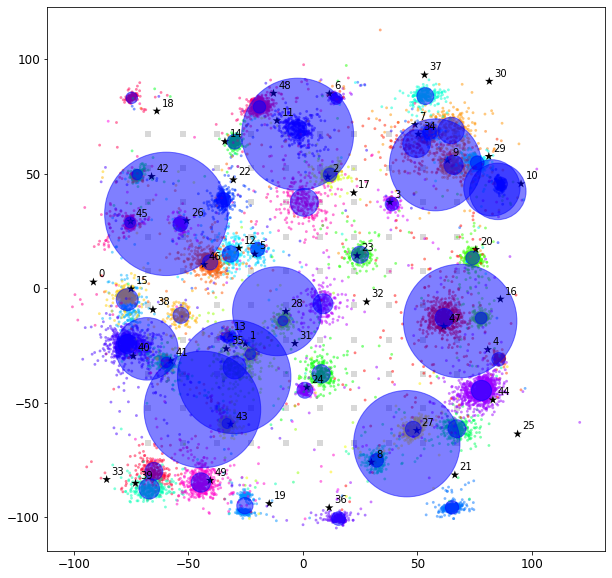

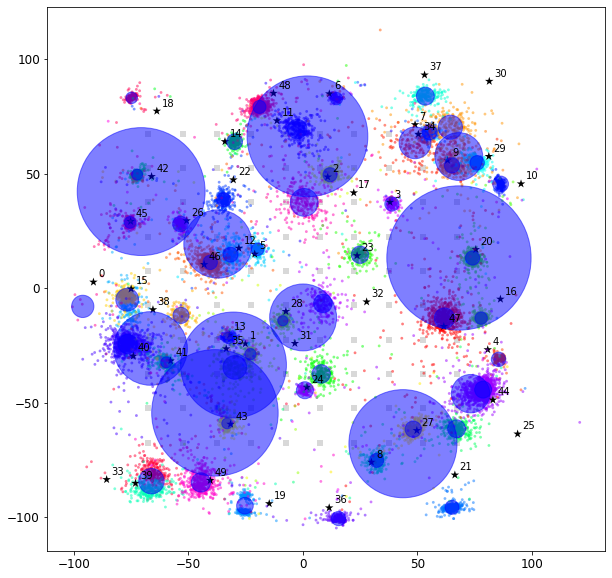

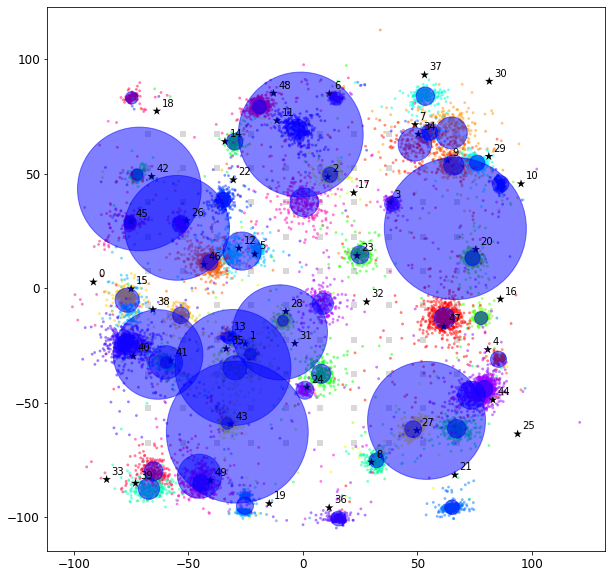

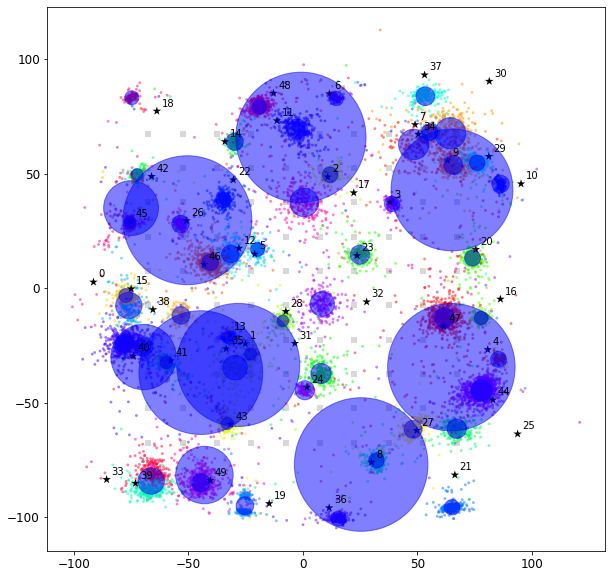

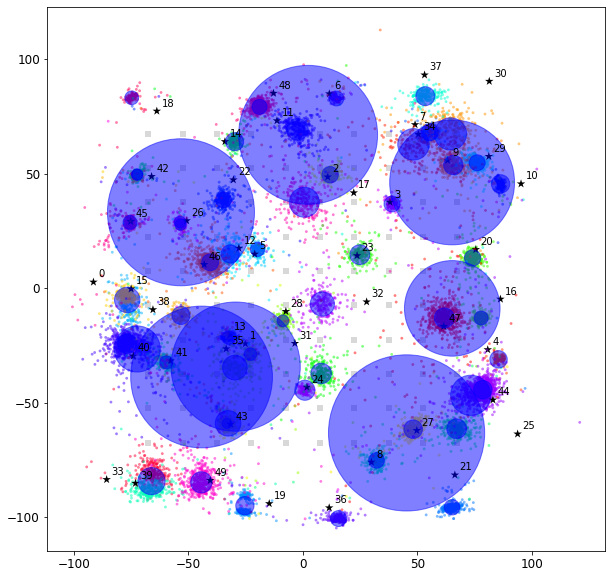

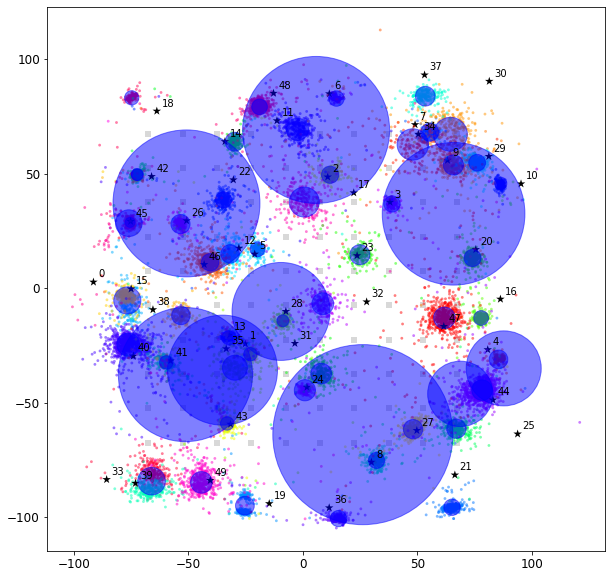

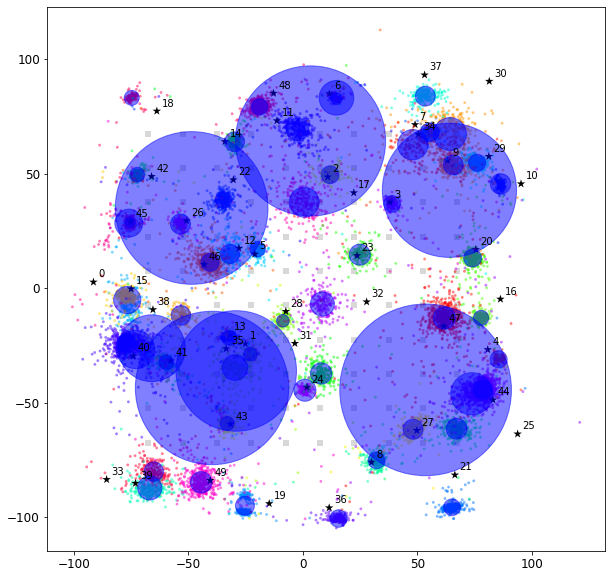

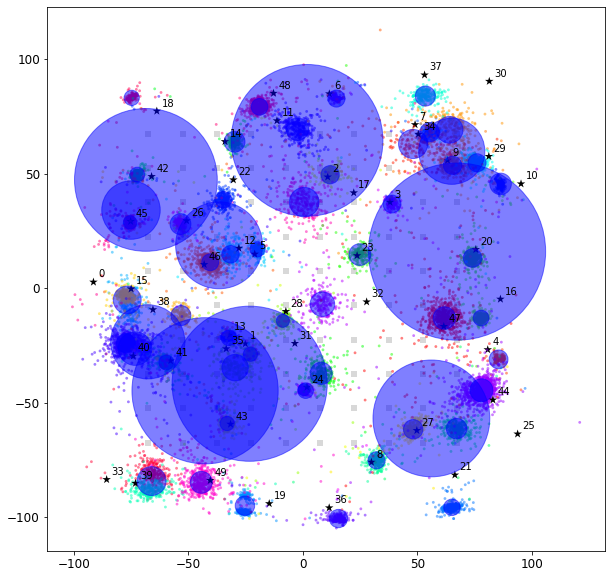

In [8]:
num_neurons = 50
cutout_start = 20
cutout_end = 20
pc_components = 2
#alpha = 8
#bandwidth_com = 5.5
num_clusters = 60
covariance_type = 'spherical'
middle_frame = len(all_neuron_waveforms[0][0])//2

waveforms_list = []
for neuron in range(num_neurons):
    for waveform in all_neuron_waveforms[neuron]:
        waveforms_list.append(waveform[middle_frame-cutout_start:middle_frame+cutout_end])
waveforms_list = np.asarray(waveforms_list)

if(pc_components != 0):
    pca = decomposition.PCA(n_components=pc_components, whiten=True)
    pca.fit(waveforms_list)
    waveforms_pcs_array = pca.transform(waveforms_list)
    all_neuron_pcs = defaultdict(list)
    total_spikes = 0
    for neuron in range(num_neurons):
        for i, _ in enumerate(all_neuron_waveforms[neuron]):
            all_neuron_pcs[neuron].append(waveforms_pcs_array[i + total_spikes])
        total_spikes += len(all_neuron_waveforms[neuron])

accuracy_vae_GMM = []
recall_vae_GMM = []
precision_vae_GMM = []

accuracy_vae_MS_all = []
recall_vae_MS_all = []
precision_vae_MS_all = []

# Clustering with GMM
for alpha in tqdm(range(21)):
    wandb.log({"alpha": alpha})
    cluster_data = []
    labels = []
    if(pc_components !=0):
        for neuron in range(num_neurons):
            for i, vae_loc in enumerate(vae_locs_3D[neuron]):
                cluster_data.append(np.concatenate((vae_loc[1:3], alpha*all_neuron_pcs[neuron][i])))
                labels.append(neuron)
        cluster_data = np.asarray(cluster_data)
    else:
        for neuron in range(num_neurons):
            for i, vae_loc in enumerate(vae_locs_3D[neuron]):
                cluster_data.append((vae_loc[1:3]))
                labels.append(neuron)
        cluster_data = np.asarray(cluster_data)

    clustering = GaussianMixture(n_components=num_clusters, covariance_type=covariance_type, random_state=0).fit(cluster_data)
    labels =  clustering.predict(cluster_data)

    #Make numpy extractor for method

    SX=se.NumpySortingExtractor()
    SX.set_sampling_frequency(32000)
    times = []
    for neuron in range(num_neurons):
        for time in all_spike_times[neuron]:
            times.append(time)
    times = np.asarray(times)
    for k in np.unique(labels):
        times_k=times[np.where(labels==k)[0]]
        times_k.sort()
        SX.add_unit(unit_id=k,times=times_k)

    cmp = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX, n_jobs=1, match_score=0);
    performance_measures = cmp.get_performance(method='pooled_with_average')

    print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
    print(performance_measures)
    
    accuracy_vae_GMM.append(performance_measures[0])
    recall_vae_GMM.append(performance_measures[1])
    precision_vae_GMM.append(performance_measures[2])
    
    wandb.log({
        "accuracy_vae_GMM": performance_measures[0],
        "recall_vae_GMM": performance_measures[1],
        "precision_vae_GMM": performance_measures[2],
        "false_discovery_rate_vae_GMM": performance_measures[3],
        "miss_rate_vae_GMM": performance_measures[4]
    })

    recgen = mr.load_recordings(recording_directory + recording_name)
    channel_positions = recgen.channel_positions

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # clustering_plotting_functions.plotClusterResults(channel_positions, cluster_data, labels, soma_positions, dims=[0,1], clustering_alg='gmm', alpha=.15, ax=ax, min_cluster_size=0)
    for i, covar in enumerate(clustering.covariances_):
        mean = clustering.means_[i]
        if covariance_type == 'full':
            covariances = covar[:2, :2]
        elif covariance_type == 'diag':
            covariances = np.diag(covar[:2])
        elif covariance_type == 'spherical':
            covariances =  np.eye(mean.shape[0]) * covar
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1],
                                  180 + angle, color='blue')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    clustering_plotting_functions.plot2DLocations(channel_positions, range(num_neurons), vae_locs_3D, soma_positions, dims=[1,2], alpha=.5, ax=ax);
    
    wandb.log({
        "Clustering GMM colorful VAE": wandb.Image(plt)
    })


    accuracy_vae_MS = []
    recall_vae_MS = []
    precision_vae_MS = []
    
    for bandwidth in range(1,21):
        wandb.log({"bandwidth_vae": bandwidth})
        
        clustering_vae= MeanShift(bandwidth=bandwidth).fit(cluster_data)
        labels_vae =  clustering_vae.predict(cluster_data)

        #plotting
        SX_groundtruth = se.MEArecSortingExtractor(recording_directory + recording_name)
        SX_vae_ms=se.NumpySortingExtractor()
        SX_vae_ms.set_sampling_frequency(32000)
        times = []
        for neuron in range(num_neurons):
            for time in all_spike_times[neuron]:
                times.append(time)
        times = np.asarray(times)
        for k in np.unique(labels_vae):
            times_k=times[np.where(labels_vae==k)[0]]
            times_k.sort()
            SX_vae_ms.add_unit(unit_id=k,times=times_k)

        cmp_vae_ms = sc.compare_sorter_to_ground_truth(SX_groundtruth, SX_vae_ms, n_jobs=1, match_score=0);
        performance_measures_vae_ms = cmp_vae_ms.get_performance(method='pooled_with_average')

        print("Alpha: " + str(alpha) + "," + " PCs: " + str(pc_components) + "," + " Num Clusters: " + str(num_clusters))
        print(performance_measures_vae_ms)
        
        wandb.log({
            "accuracy_vae_meanshift": performance_measures_vae_ms[0],
            "recall_vae_meanshift": performance_measures_vae_ms[1],
            "precision_vae_meanshift": performance_measures_vae_ms[2],
            "false_discovery_rate_vae_meanshift": performance_measures_vae_ms[3],
            "miss_rate_vae_meanshift": performance_measures_vae_ms[4]
        })

        accuracy_vae_MS.append(performance_measures_vae_ms[0])
        recall_vae_MS.append(performance_measures_vae_ms[1])
        precision_vae_MS.append(performance_measures_vae_ms[2])
        
    
    accuracy_vae_MS_all.append(accuracy_vae_MS)
    recall_vae_MS_all.append(recall_vae_MS)
    precision_vae_MS_all.append(precision_vae_MS)
    
    

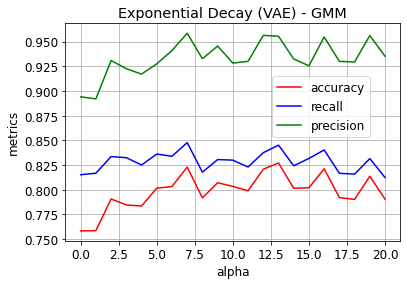

In [33]:
plt.plot(range(0,21),accuracy_vae_GMM, label = 'accuracy', color = 'red')
plt.plot(range(0,21),recall_vae_GMM, label = 'recall', color = 'blue')
plt.plot(range(0,21),precision_vae_GMM, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Exponential Decay (VAE) - GMM')
plt.legend(loc=0, bbox_to_anchor=(0.6,0.45))
plt.grid()

wandb.log({
    "Alpha for GMM VAE": wandb.Image(plt)
})

plt.show()

In [10]:
acc_vae_ms = []
re_vae_ms = []
pre_vae_ms = []
for i in range(21):
    acc_vae_ms.append(max(accuracy_vae_MS_all[i]))
    re_vae_ms.append(max(recall_vae_MS_all[i]))
    pre_vae_ms.append(max(precision_vae_MS_all[i]))


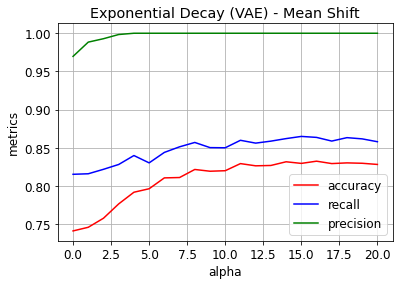

In [34]:
plt.plot(range(0,21),acc_vae_ms, label = 'accuracy', color = 'red')
plt.plot(range(0,21),re_vae_ms, label = 'recall', color = 'blue')
plt.plot(range(0,21),pre_vae_ms, label = 'precision', color = 'green')
plt.xlabel('alpha')
plt.ylabel('metrics')
plt.title('Exponential Decay (VAE) - Mean Shift')
plt.grid()
plt.legend()

wandb.log({
    "Alpha for Mean Shift VAE": wandb.Image(plt)
})
plt.show()


* 

## For New Method

In [36]:
neu_errors_old = [np.mean(all_vae_errors[i]) for i in all_vae_errors]

In [90]:
neu_errors_new = [np.mean(all_vae_errors[i]) for i in all_vae_errors]

In [91]:
neu_errors_new

[22.684026909139206,
 5.580610073943032,
 5.0817104658792,
 4.074716581279914,
 6.547238671269062,
 4.640337835155674,
 4.0983352376568725,
 8.351050450317755,
 4.729433260524375,
 6.8739488187930355,
 9.103657019704139,
 13.650086455950156,
 11.236679981801664,
 2.221953003596431,
 5.810949787734439,
 8.045111401382407,
 12.683597862128574,
 25.913390401415388,
 13.277789251112228,
 12.803382622516121,
 5.480328895180771,
 14.898114865204354,
 12.269047437925034,
 7.1863986828137465,
 3.284991623368249,
 27.264812924588544,
 4.7943788076912135,
 4.806120878389498,
 6.053173998327492,
 7.517270705153834,
 32.55497191849004,
 19.40091248331849,
 25.11356117931671,
 23.52790848764682,
 16.07262989516571,
 16.186896321619308,
 7.526238437329227,
 11.857274505443385,
 15.40260459882695,
 12.373685997210384,
 12.322989774740616,
 3.4997033883436144,
 6.620961020250026,
 3.565178628663666,
 10.891119798813017,
 2.9985708015965526,
 9.990321376231154,
 10.851629831080606,
 10.491531130809806,

(-1.4255014646655044, 56.05469286798329)

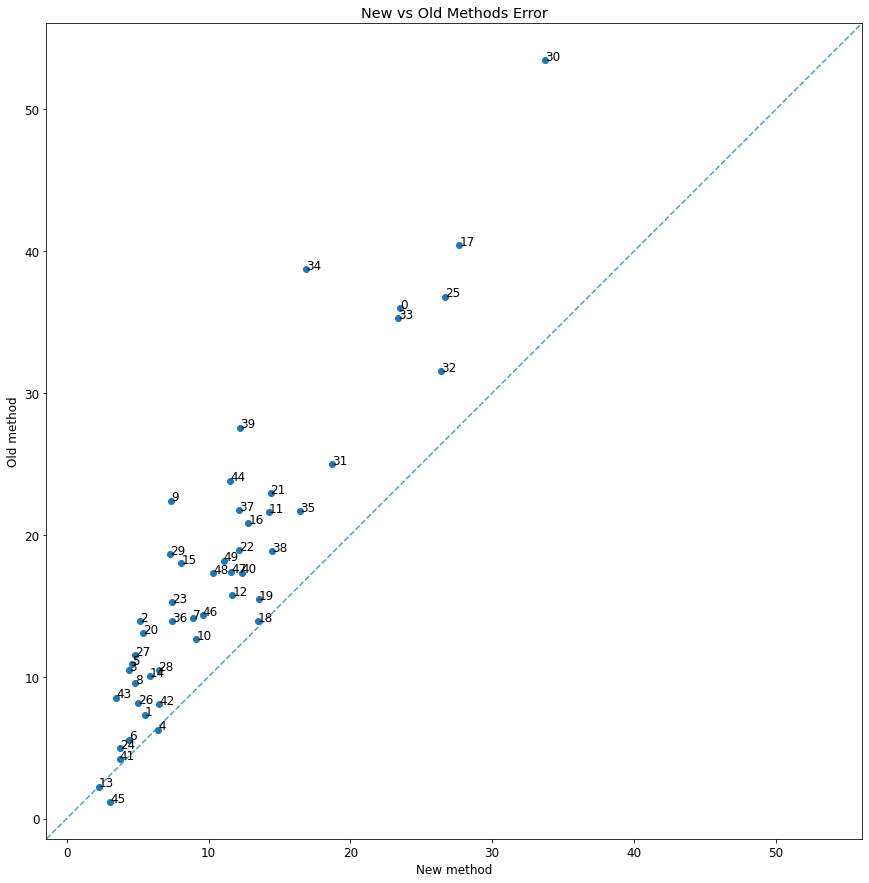

In [50]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(neu_errors_new, neu_errors_old)
plt.xlabel('New method')
plt.ylabel('Old method')
plt.title('New vs Old Methods Error')

for i in range(50):
    ax.annotate(str(i), (neu_errors_new[i], neu_errors_old[i]))
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, '--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

## Monopolar Triangulation

In [63]:
#importing libraries

from decay_model.utility_functions import data_augmentation_functions_new
from tqdm.notebook import tqdm
from probeinterface.plotting import plot_probe
from decay_model.utility_functions import clustering_plotting_functions

import numpy as np
import matplotlib.pyplot as plt
import h5py
#import wandb
import matplotlib as mpl

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeextractors as see
import spikeinterface.comparison as sc
import MEArec as mr

from sklearn.mixture import GaussianMixture
from sklearn import decomposition
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from collections import defaultdict
from spikeinterface.sortingcomponents.peak_localization import localize_peaks


In [64]:
recording_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/'
recording_name = 'recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5'
save_directory = '/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/peak localize files/'

#
width = 40 # The distance from the channel with the largest amplitude spike for which channels are included in the constructed data (microns).
spike_jitter = 5 # The number of frames used to align the extracted waveforms. We search within +-5 frames of the ground truth spike time to find the true peak.
amp_jitter = 0 # The amplitude jitter hyperparameter (described in the manuscript)
save = True # Save the dataset to the save_directory if True

In [65]:
file_name = recording_directory + recording_name
print(file_name)
recgen = mr.load_recordings(file_name)
soma_positions = [st.annotations['soma_position'] for st in recgen.spiketrains]
#channel_positions = recgen.channel_positions

recording, sorting = se.read_mearec(file_name)

/Users/zelihasag/All Files/Edinburgh Courses/Dissertation/recordings_50cells_SqMEA-10-15um_60.0_10.0uV_27-03-2019_13-31-005.h5


BandpassFilterRecording: 100 channels - 1 segments - 32.0kHz - 60.000s
CommonReferenceRecording: 100 channels - 1 segments - 32.0kHz - 60.000s
Use cache_folder=/var/folders/yh/nyq5m3zj111bg647cmllz8s00000gn/T/spikeinterface_cache/tmp0u37i6zk/0ULH6VB3
write_binary_recording with n_jobs 1  chunk_size None
BinaryRecordingExtractor: 100 channels - 1 segments - 32.0kHz - 60.000s
  file_paths: ['/var/folders/yh/nyq5m3zj111bg647cmllz8s00000gn/T/spikeinterface_cache/tmp0u37i6zk/0ULH6VB3/traces_cached_seg0.raw']


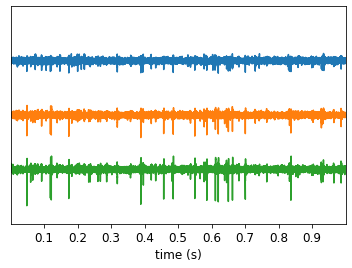

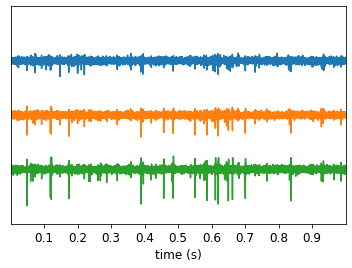

In [66]:
recording_f = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)
# Looking at the data after bandpass filter
w = sw.plot_timeseries(recording_f, channel_ids=['1', '2', '3'])

#recording_notch = st.notch_filter(recording, freq=2000, q=30)
#print(recording_notch)
#w_notch = sw.plot_timeseries(recording_notch, channel_ids=['1', '2', '3'])

recording_cmr = st.common_reference(recording_f, reference='global', operator='median')
print(recording_cmr)
# We can also apply other preprocessing steps to further increase the quality of the recording. 
# Common Median Reference (CMR)
w_cmr = sw.plot_timeseries(recording_cmr, channel_ids=['1', '2', '3'])

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

In [67]:
waveforms = si.WaveformExtractor.create(recording_preprocessed, sorting, 'waveforms new', remove_if_exists=True)
waveforms.set_params(ms_before=1, ms_after=1.5, max_spikes_per_unit=None)
waveforms.run_extract_waveforms(n_jobs=-1, chunk_size=30000, progress_bar=True)
print(waveforms)

extract waveforms memmap: 100%|█████████████████| 64/64 [00:43<00:00,  1.48it/s]


WaveformExtractor: 100 channels - 50 units - 1 segments
  before:32 after:48 n_per_units:None


In [68]:
job_kwargs = dict(chunk_duration='1s', n_jobs=-1, progress_bar=True)

peaks = st.get_peaks_from_templates(
    waveforms,
    peak_sign="both",
    radius_um=20,
    **job_kwargs,
)


compute waveform features: 100%|███████████████| 60/60 [00:00<00:00, 457.71it/s]


In [69]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

job_kwargs = dict(chunk_duration='1s', n_jobs=1, progress_bar=True)

peak_locations_mt = localize_peaks(recording_preprocessed, peaks, method= 'monopolar_triangulation',
                                ms_before=1, ms_after=1, method_kwargs={'local_radius_um': 20, 'max_distance_um': 100, 'optimizer': 'least_square'}, **job_kwargs)



localize peaks: 100%|###########################| 60/60 [01:18<00:00,  1.31s/it]


In [70]:
from collections import defaultdict

s= sorting.get_all_spike_trains()[0]

all_errors_mt = defaultdict(list)
all_locations_mt = defaultdict(list)


for i in range(len(peak_locations_mt)): #len(peak_locations)):
    
    unit_id = int(s[1][i][1:])
    neuron_pos = soma_positions[unit_id]
    est_pos_mt = peak_locations_mt[i]
    error_dist_mt = np.linalg.norm(np.array([est_pos_mt['x'], est_pos_mt['y']]) - neuron_pos[1:3])
    all_errors_mt[unit_id].append(error_dist_mt)
    all_locations_mt[unit_id].append([est_pos_mt['x'], est_pos_mt['y']])


In [71]:
neuron_error_mt = 0
neuron_std_mt = 0 
neuron_errors_all_mt = []
neuron_stds_all_mt = []
spike_errors_all_mt = []


for neuron in range(50):#good_indices:#range(50):
    if(len(all_errors_mt[neuron]) != 0):
        neuron_error_mt = np.mean(all_errors_mt[neuron])
        neuron_std_mt = np.std(all_errors_mt[neuron])
        spike_errors_all_mt = spike_errors_all_mt + all_errors_mt[neuron]
        neuron_errors_all_mt.append(neuron_error_mt)
        neuron_stds_all_mt.append(neuron_std_mt)
print("Total Spike 2D Error: " + str(np.mean(spike_errors_all_mt)) + " +- " + str(np.std(spike_errors_all_mt)))
print("Total Neuron 2D Error: " + str(np.mean(neuron_errors_all_mt)) + " +- " + str(np.mean(neuron_stds_all_mt)))


Total Spike 2D Error: 10.356252911030412 +- 11.251930606144576
Total Neuron 2D Error: 11.653031174274005 +- 8.166821736423797


In [72]:
neu_errors_monopolar = []
for i in range(50):
    neu_errors_monopolar.append(np.mean(all_errors_mt[i])) 

In [92]:
neu_errors_monopolar

[22.70348045403095,
 5.087008189505302,
 4.412548248915071,
 5.566126666153105,
 4.4684231854974605,
 2.5573656717196984,
 3.1183649698934977,
 11.973007096381744,
 10.954945706322418,
 9.969785876240032,
 12.239757061138752,
 16.490500347464625,
 14.382541177540428,
 1.7940258509542955,
 6.595587337364796,
 10.198099016191696,
 12.903803791185648,
 24.362288477609503,
 5.189969549533945,
 9.591639917226688,
 8.257247240835145,
 16.06034363548755,
 14.654746631482064,
 7.686575908007861,
 2.50475038070706,
 25.65510305445203,
 3.528343481389641,
 14.203410057580516,
 4.809262284492902,
 11.144986295656556,
 32.327943946241305,
 18.744480649913754,
 23.455159155513922,
 28.58043923583908,
 25.014640954851426,
 19.837572066415362,
 10.36853377297829,
 13.401887109702532,
 12.624293677132115,
 17.47174069185514,
 11.952397599590906,
 1.4634498437572567,
 5.986170956973845,
 4.309392168594687,
 12.643519039363957,
 2.8982767907782696,
 5.055283377564373,
 11.253790107479041,
 7.88189224124

In [68]:
# neu_errors_mono = [np.mean(all_errors_mt[i]) for i in all_errors_mt]
# neu_errors_mono

[4.151118929759271,
 11.484666294374204,
 9.215135432589681,
 27.66338738714709,
 12.196160227583851,
 10.409147618663665,
 14.039567375159649,
 14.837856626252453,
 31.473837260674312,
 6.6516481632229,
 11.515562635689088,
 25.30023511739541,
 12.31210594959073,
 8.171040584235856,
 2.571947778826877,
 4.761658932925987,
 14.309040823519627,
 1.856996732526359,
 13.827246500026956,
 6.587346243726292,
 12.29410517000613,
 23.904734010473078,
 2.787338220452323,
 6.777751176658229,
 4.712460310106719,
 16.105779104638373,
 14.172054242433864,
 27.489928764089065,
 8.518793781390132,
 4.594568085359081,
 10.130073193815052,
 18.99112337642411,
 5.815282087180997,
 3.4826733620072012,
 21.482030001631525,
 9.880210934366113,
 13.352256926215214,
 29.113206013702943,
 21.019092298365667,
 17.224881306927173,
 8.944955883584718,
 12.314252174593367,
 6.552934436827519,
 6.463401372955942,
 19.19919768492238,
 15.406422723380548,
 24.861849616522832,
 7.5781911806159075,
 5.412573164769066

(-0.07977486136694578, 34.07162286423472)

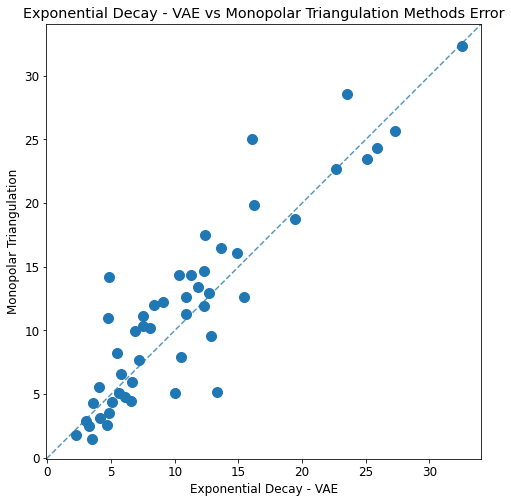

In [98]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(neu_errors_new, neu_errors_monopolar, s=100)
plt.xlabel('Exponential Decay - VAE')
plt.ylabel('Monopolar Triangulation')
plt.title('Exponential Decay - VAE vs Monopolar Triangulation Methods Error')

for i in range(50):
    ax.annotate(str(''), (neu_errors_new[i], neu_errors_monopolar[i]))
    
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, '--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)